Импорт библиотек

In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from utils.train import Trainer
from utils.models import LSTMModel
from utils.data import TSDataset, DataTransform

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Настройка отображения графиков

In [2]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

fig_size = plt.rcParams["figure.figsize"]
fig_size[0], fig_size[1] = 20, 8
plt.rcParams["figure.figsize"] = fig_size

Чтение данных

In [3]:
df = pd.read_excel('data/ts.xlsx', index_col='ds')
df = df.sort_index().copy()
df.head()

,value
ds,
2017-05-06,6.015413e+06
2017-05-07,6.020499e+06
2017-05-08,6.478914e+06
2017-05-09,5.799986e+06
2017-05-10,7.683149e+06


Разделение на обучающую и валидационную выборку

In [4]:
test_size = 30
threshold = len(df) - test_size

train, test = df['value'][:threshold], df['value'][threshold:]

print('length train: {:>4} | test {:>4}'.format(len(train), len(test)))

length train:  970 | test   30


Преобразование данных. Используется для приведение ряда к стационарному

In [5]:
dt_train = DataTransform(const=train[0])
trans_train = dt_train.transform(data=train[1:])

dt_test = DataTransform(const=train[-1])
trans_test = dt_test.transform(data=test)

print('length train: {:>4} | test {:>4}'.format(len(trans_train), len(trans_test)))

length train:  969 | test   30


Подготовка структуры данных для модели

In [6]:
history_size = 90

ds_train = TSDataset(trans_train, history_size=history_size)
ds_test = TSDataset(trans_train[-history_size:] + trans_test, history_size=history_size)
print('length train: {:>4} | test {:>4}'.format(len(ds_train), len(ds_test)))

train_dl = DataLoader(dataset=ds_train, batch_size=128, shuffle=False)
test_dl = DataLoader(dataset=ds_test, batch_size=128, shuffle=False)

length train:  879 | test   30


Инициализация функции ошибки, модели и класса для обучения модели

In [7]:
criterion = nn.MSELoss()
learning_rate = 1e-2
model = LSTMModel()

trainer = Trainer(criterion=criterion, device=device, model=model, learning_rate=learning_rate)

Обучение модели

In [8]:
trainer.fit(train_dataloader=train_dl, val_dataloader=test_dl, n_epochs=50, verbose=True)

   0/50 train: 0.0190 | val: 0.0192
  10/50 train: 0.0098 | val: 0.0167
  20/50 train: 0.0090 | val: 0.0127
  30/50 train: 0.0089 | val: 0.0132
  40/50 train: 0.0093 | val: 0.0116


Отрисовка предсказанных значений и фактических

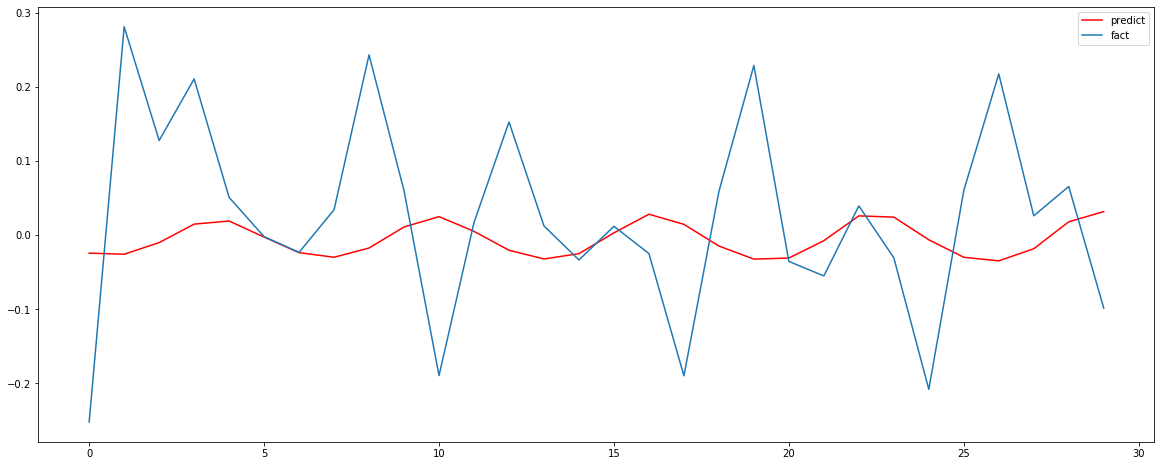

In [11]:
plt.plot(trainer.predict(n_pred=len(trans_test)), color='red', label='predict')
plt.plot(trans_test, label='fact')
plt.legend()